In [84]:
import os, cv2, pickle, subprocess, re, numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [85]:
# Carica e restituisce un np.array contenente tutti i frame connessi
def load_frames(input_path):
    all_files = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]

    frames = []
    for frame_file in all_files:
        frame_path = os.path.join(input_path, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame.flatten())  

    return np.array(frames)

# Train and return pca model trained on data
def train_pca_model(frames, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(frames)
    return pca

# Compress and save data
def apply_pca(pca_model, frames, original_shape, names):
    compressed_frames = pca_model.transform(frames)
    serialize_pca(original_shape, compressed_frames, names, '../results/PCA/')
    
# Serialize data into bytes file
def serialize_pca(original_shape, compressed_data, frame_names, output_path):
    data_to_save = {
        'compressed_data': compressed_data,
        'original_shape': original_shape,
        'frame_names': frame_names,
    }
    with open(output_path + 'compressed_data.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)
        
# Deserialize data into orginal format
def deserialize_pca(input_path):
    with open(input_path, 'rb') as f:
        data = pickle.load(f)
    return data['compressed_data'], data['original_shape'], data['frame_names']

# Load received frames and save
def transform_and_save(pca_object, frames, original_shape, frame_names):
    reconstructed_frames = pca_object.inverse_transform(frames)
    
    os.makedirs("../results/PCA/decoder_output/", exist_ok = True)
    
    for i, frame in enumerate(reconstructed_frames):
        frame_reshaped = frame.reshape(original_shape).astype(np.uint8) 
        save_path = os.path.join("../results/PCA/decoder_output/", frame_names[i])
        cv2.imwrite(save_path, cv2.cvtColor(frame_reshaped, cv2.COLOR_RGB2BGR))


# Split Section

In [86]:
# import os, shutil, random

# def split_data(dataset_name):
#     # Percorso della cartella con le immagini
#     base_folder = "../datasets/"

#     # Destinazioni per train e test
#     train_folder = "../pca_datasets/train/" + dataset_name + "/"
#     test_folder = "../pca_datasets/test/" + dataset_name + "/"

#     # Crea le cartelle di destinazione
#     os.makedirs(train_folder, exist_ok = True)
#     os.makedirs(test_folder, exist_ok = True)

#     # Lista delle immagini
#     images = [f for f in os.listdir(base_folder + dataset_name) if os.path.isfile(os.path.join(base_folder + dataset_name, f))]

#     # Shuffle delle immagini
#     random.seed(42)  # Per riproducibilità
#     random.shuffle(images)

#     split_index = int(0.7 * len(images))

#     train_images = images[:split_index]
#     test_images = images[split_index:]

#     # Sposta i file
#     for img in train_images:
#         shutil.copy(os.path.join(base_folder + dataset_name, img), os.path.join(train_folder, img))

#     for img in test_images:
#         shutil.copy(os.path.join(base_folder + dataset_name, img), os.path.join(test_folder, img))

In [87]:
# names = ["ArtGallery", "Blob", "Car", "Cobblestone", "Dice", "Dragons", "Fish", "Mannequin", "Messerschmitt"]
# for name in names:
#     split_data(name)

# Simulation Section

In [88]:
# # Encoder simulation

# dataset_name = "Messerschmitt"
# n_components = 60
# train_input_path = "../pca_datasets/train/" + dataset_name + "/"

# compact_frames = load_frames(train_input_path)

# all_files = [f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))]
# sample_frame = cv2.imread(os.path.join(train_input_path, all_files[0]))
# original_shape = sample_frame.shape

# pca_object = train_pca_model(compact_frames, n_components)

# test_input_path = "../pca_datasets/test/" + dataset_name + "/"
# test_names = [f for f in os.listdir(test_input_path) if os.path.isfile(os.path.join(test_input_path, f))]
# test_frames = load_frames(test_input_path)

# apply_pca(pca_object, test_frames, original_shape, test_names)

In [89]:
# # Decoder simulation

# dataset_name = "Messerschmitt"
# input_path = "../pca_datasets/test/" + dataset_name + "/"
# output_path = "../results/PCA/" + dataset_name + "/"

# frames_compressed, original_shape, names = deserialize_pca('../results/PCA/compressed_data.pkl')
# transform_and_save(pca_object, frames_compressed, original_shape, names)

# Evaluation Section

In [90]:
def calculate_metrics(decompressed_path, original_path):  
    # Esegui il comando per calcolare SSIM usando ffmpeg
    ssim_result = subprocess.run(
        ["../../bin/ffmpeg", "-i", decompressed_path, "-i", original_path, "-lavfi", "ssim=stats_file=ssim_logfile.txt", "-f", "null", "-"],
        capture_output = True, text = True
    )
    
    # Esegui il comando per calcolare PSNR usando ffmpeg
    psnr_result = subprocess.run(
        ["../../bin/ffmpeg", "-i", decompressed_path, "-i", original_path, "-lavfi", "psnr=stats_file=psnr_logfile.txt", "-f", "null", "-"],
        capture_output = True, text = True
    )
    
    # Estrai il valore SSIM dal log
    ssim_match = re.search(r"All:([\d.]+)", ssim_result.stderr)
    ssim = float(ssim_match.group(1)) if ssim_match else None

    # Estrai il valore PSNR medio dal log
    psnr_match = re.search(r"average:([\d.]+)", psnr_result.stderr)
    #print(psnr_result.stderr)
    psnr = float(psnr_match.group(1)) if psnr_match else None
    
    return ssim, psnr


def plot_metrics(ssim_values, psnr_values, execution_times, compressed_sizes, pca_components):
    psnr_values = [0 if x is None else x for x in psnr_values]

    plt.figure(figsize=(12, 16))

    def annotate_values(x, y, ax):
        for i, val in enumerate(y):
            ax.text(x[i], y[i], f"{val:.2f}", fontsize=10, color="black", ha="right", va="bottom")

    # Grafico SSIM
    ax1 = plt.subplot(4, 1, 1)
    ax1.plot(pca_components, ssim_values, marker='o', color='blue', label='SSIM')
    plt.xticks(pca_components)
    plt.title("SSIM in base al numero di componenti PCA", fontsize=14)
    plt.xlabel("Numero di componenti PCA", fontsize=12)
    plt.ylabel("SSIM", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(pca_components, ssim_values, ax1)

    # Grafico PSNR
    ax2 = plt.subplot(4, 1, 2)
    ax2.plot(pca_components, psnr_values, marker='s', color='orange', label='PSNR')
    plt.xticks(pca_components)
    plt.title("PSNR in base al numero di componenti PCA", fontsize=14)
    plt.xlabel("Numero di componenti PCA", fontsize=12)
    plt.ylabel("PSNR (dB)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(pca_components, psnr_values, ax2)

    # Grafico Tempo di Esecuzione
    ax3 = plt.subplot(4, 1, 3)
    ax3.plot(pca_components, execution_times, marker='^', color='green', label='Tempo di Esecuzione')
    plt.xticks(pca_components)
    plt.title("Tempo di esecuzione in base al numero di componenti PCA", fontsize=14)
    plt.xlabel("Numero di componenti PCA", fontsize=12)
    plt.ylabel("Tempo di esecuzione (s)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(pca_components, execution_times, ax3)

    # Grafico Dimensione del File Compresso
    ax4 = plt.subplot(4, 1, 4)
    ax4.plot(pca_components, compressed_sizes, marker='v', color='purple', label='Dimensione del File Compresso')
    plt.xticks(pca_components)
    plt.title("Dimensione del file compresso in base al numero di componenti PCA", fontsize=14)
    plt.xlabel("Numero di componenti PCA", fontsize=12)
    plt.ylabel("Dimensione (KB)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    annotate_values(pca_components, compressed_sizes, ax4)

    plt.tight_layout()
    plt.savefig("metrics_vs_pca_components_with_values.png")
    plt.show()


Testing PCA compression with 1 components...
Execution time with 1 components: [5.096730470657349]
SSIM: 0.666508, PSNR: 19.616771 with 1 components
--------------------
Testing PCA compression with 3 components...
Execution time with 3 components: [5.096730470657349, 6.089654445648193]
SSIM: 0.693333, PSNR: 21.320661 with 3 components
--------------------
Testing PCA compression with 6 components...
Execution time with 6 components: [5.096730470657349, 6.089654445648193, 5.830234527587891]
SSIM: 0.698348, PSNR: 22.040359 with 6 components
--------------------
Testing PCA compression with 8 components...
Execution time with 8 components: [5.096730470657349, 6.089654445648193, 5.830234527587891, 8.012360572814941]
SSIM: 0.699954, PSNR: 22.557444 with 8 components
--------------------
Testing PCA compression with 10 components...
Execution time with 10 components: [5.096730470657349, 6.089654445648193, 5.830234527587891, 8.012360572814941, 7.617767810821533]
SSIM: 0.709949, PSNR: 23.3880

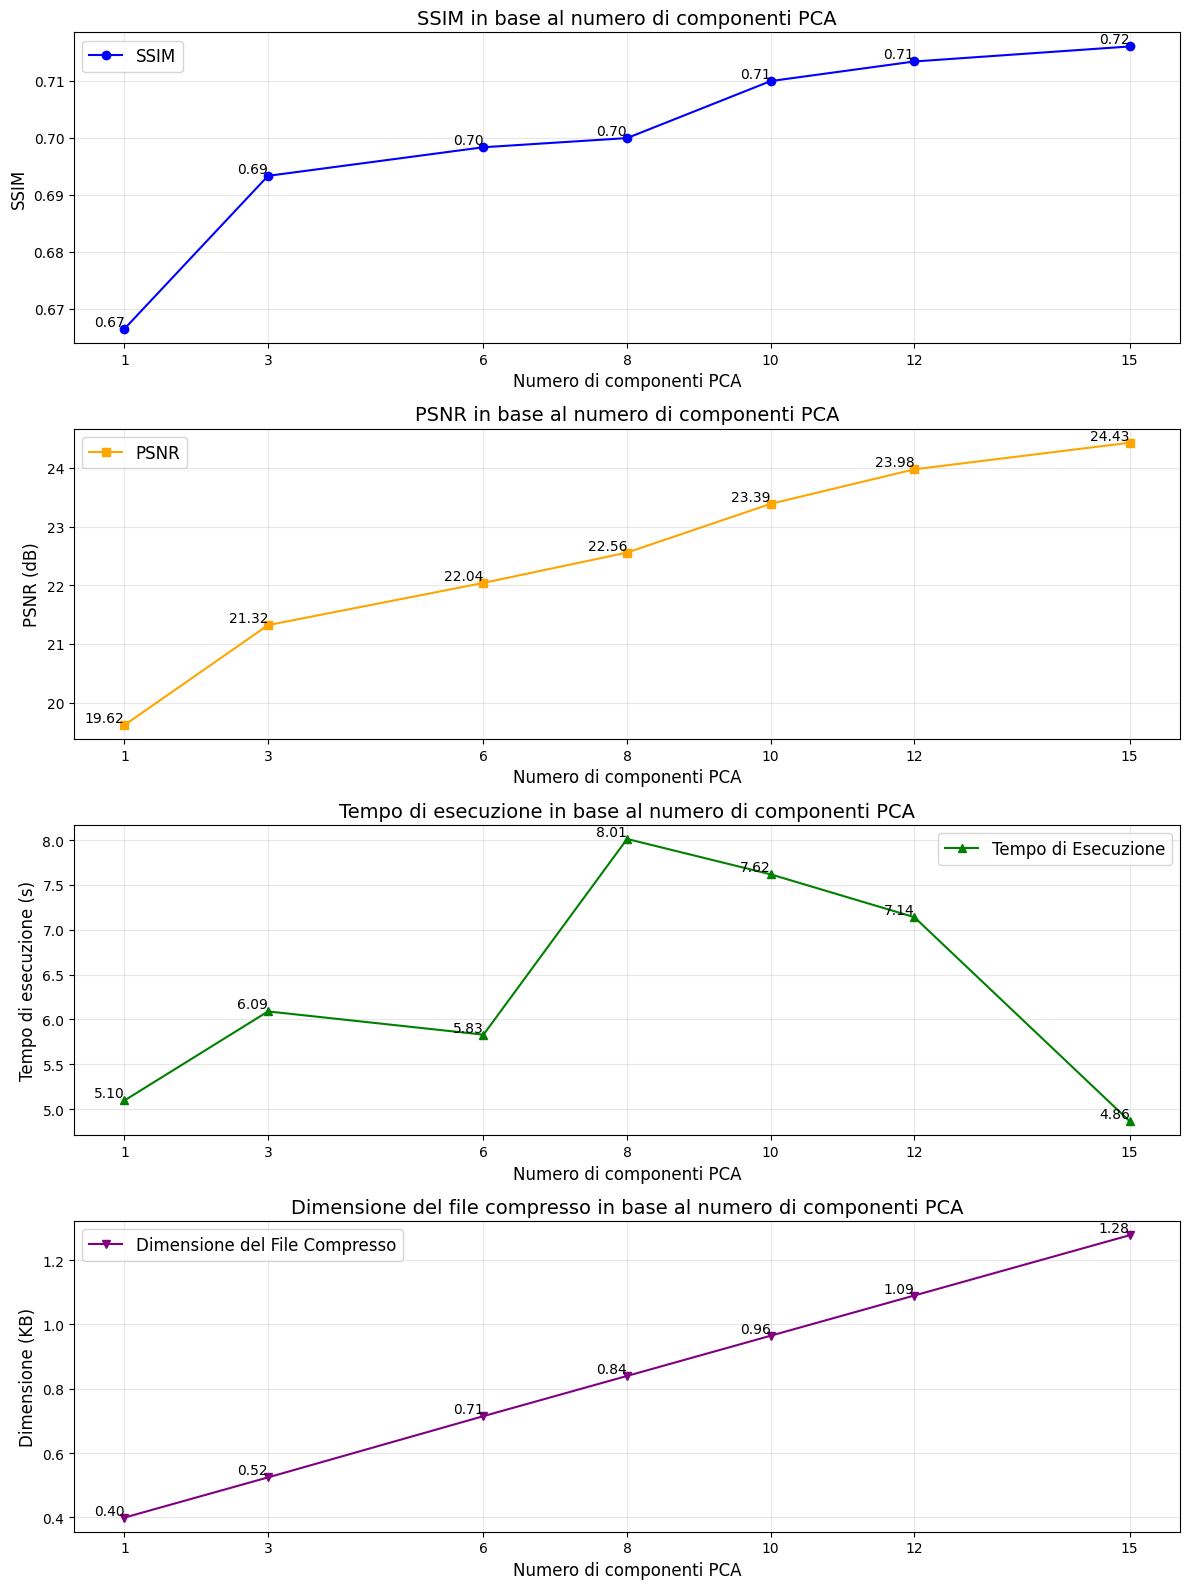

In [91]:
import time, os

dataset_name = "Messerschmitt"
train_input_path = "../pca_datasets/train/" + dataset_name + "/"

number_of_files = len([f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))])
components_range = [round(x) for x in np.linspace(1, number_of_files, 8)]
components_range = components_range[:-1]


ssim_scores, psnr_scores, execution_times, sizes = [], [], [], []
for n_components in components_range:
        print(f"Testing PCA compression with {n_components} components...")
        
        # Simulate encoder
        start_time = time.time()
        compact_frames = load_frames(train_input_path)

        all_files = [f for f in os.listdir(train_input_path) if os.path.isfile(os.path.join(train_input_path, f))]
        sample_frame = cv2.imread(os.path.join(train_input_path, all_files[0]))
        original_shape = sample_frame.shape

        pca_object = train_pca_model(compact_frames, n_components)

        test_input_path = "../pca_datasets/test/" + dataset_name + "/"
        test_names = [f for f in os.listdir(test_input_path) if os.path.isfile(os.path.join(test_input_path, f))]
        test_frames = load_frames(test_input_path)

        apply_pca(pca_object, test_frames, original_shape, test_names)
        end_time = time.time()
        
        
        execution_times.append(end_time - start_time)
        sizes.append(os.path.getsize("/workspace/results/PCA/compressed_data.pkl") / 1024)

        print(f"Execution time with {n_components} components: {execution_times}")

        # Simulate decoder
        frames_compressed, original_shape, names = deserialize_pca('../results/PCA/compressed_data.pkl')
        transform_and_save(pca_object, frames_compressed, original_shape, names)
    
        # Calcola SSIM e PSNR
        ssim, psnr = calculate_metrics("/workspace/results/PCA/decoder_output/" + names[0], "/workspace/pca_datasets/test/" + dataset_name + "/" + names[0])
        ssim_scores.append(ssim)
        psnr_scores.append(psnr)
        print(f"SSIM: {ssim}, PSNR: {psnr} with {n_components} components")
        print("-" * 20)
        
plot_metrics(ssim_scores, psnr_scores, execution_times, sizes, components_range)

In [92]:
# plot_metrics(ssim_scores, psnr_scores, execution_times, sizes, components_range)